In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import trajectory as trj

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179388757264
lat:  49.25 lon:  119.7
50527
2020-12-30 23:15:27


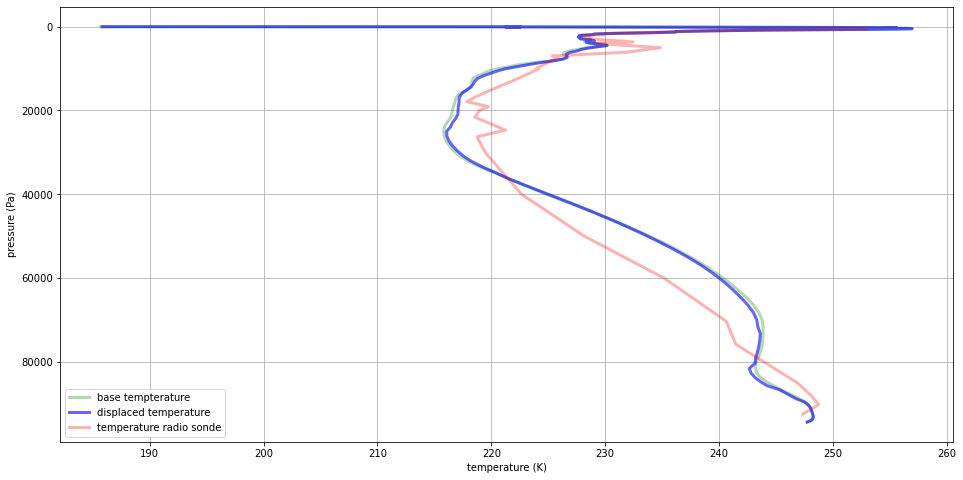

In [36]:
stat = '50527'
date_time = '2020-12-30 23:15:27'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns='observed_variable')

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns='observed_variable')

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179446801312
lat:  48.24895 lon:  16.35718
11035
2020-12-30 23:31:43


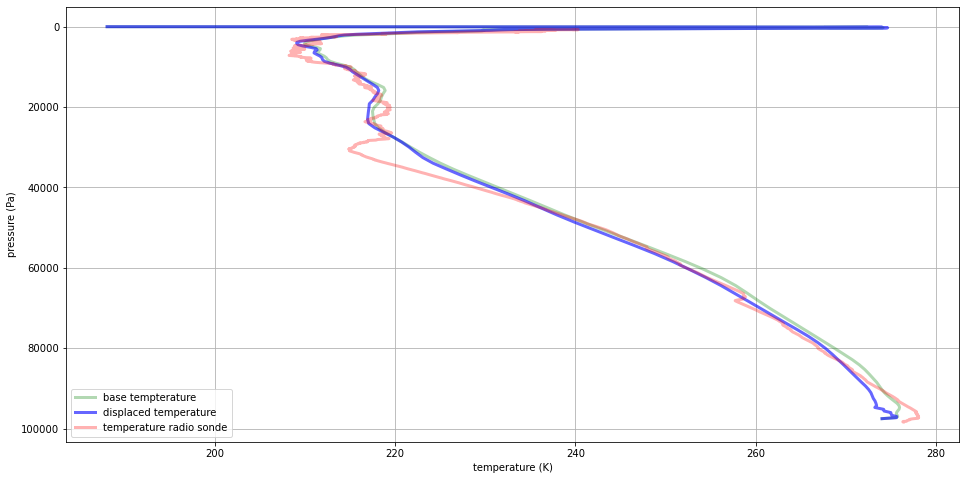

In [42]:
stat = '11035'
date_time = '2020-12-30 23:31:43'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns='observed_variable')

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns='observed_variable')

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179444069856
lat:  52.2093 lon:  14.12041
10393
2020-12-30 22:45:14


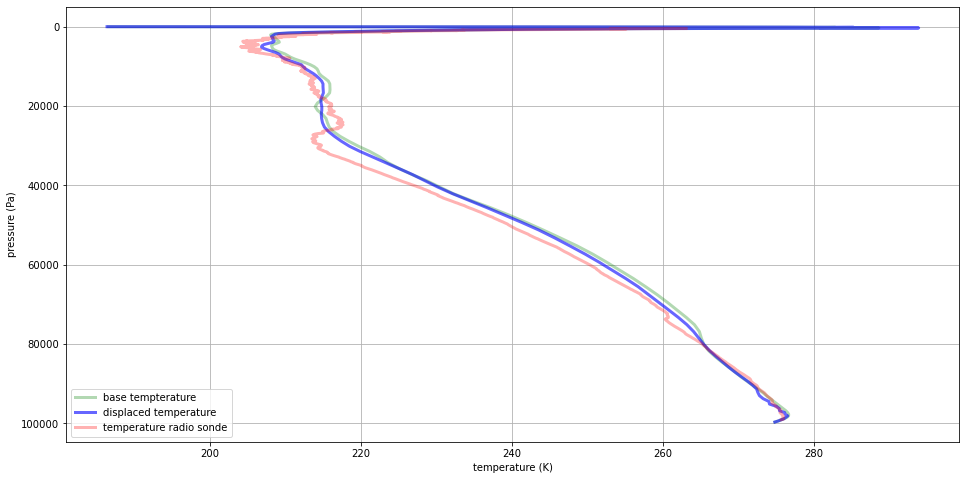

In [45]:
stat = '10393'
date_time = '2020-12-30 22:45:14'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns='observed_variable')

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns='observed_variable')

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179331665552
lat:  35.18 lon:  -97.44
72357
2020-12-31 00:00:00


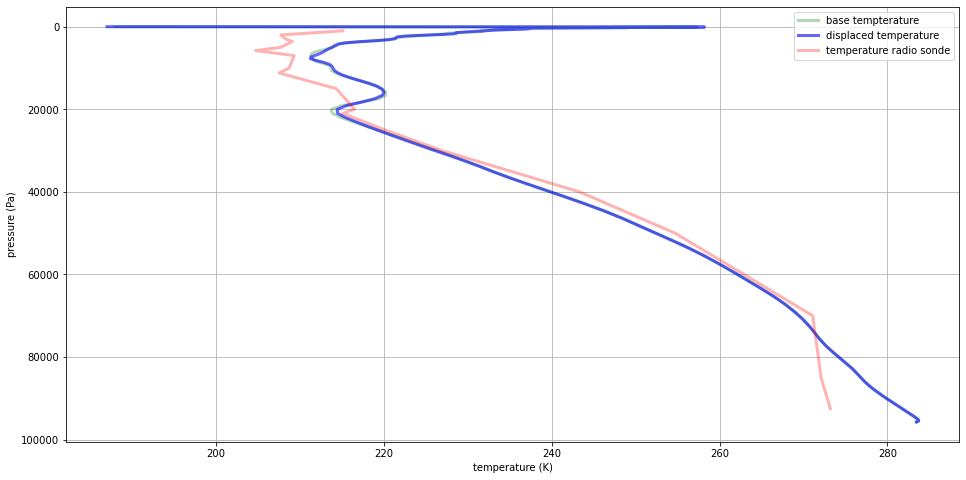

In [48]:
stat = '72357'
date_time = '2020-12-31 00:00:00'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time',])# 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns='observed_variable')

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns='observed_variable')

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()